In [1]:
# Author: Arthur Prigent
# Email: aprigent@geomar.de

In [2]:
import xarray as xr 
#import xgcm 
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import glob
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mticker
import cartopy
from scipy import stats
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime
now = datetime.now()
def data_sub(data,lon_min,lon_max,lat_min,lat_max):
    
    '''Define a box between lon_min lon_max lat_min and lat_max and 
    extract the data in the box and drop everything else.
    
    
    Parameters
    ----------
    
    data : xarray_like
    Data to be subdomained. 
    
    lon_min : integer
    Longitude minimum of the subdomain
    
    lon_max : integer
    Longitude maximum of the subdomain
    
    lat_min : integer
    Latitude minimum of the subdomain
    
    lat_max : integer
    Latitude maximum of the subdomain
    
    Returns
    ---------
    
    data_sub : xarray_like
    Subdomain. 
    '''
    
    try:
        data_sub = data.where((  data.lon>=lon_min) & (data.lon<=lon_max) & (data.lat<=lat_max) & (data.lat>=lat_min),
                                                                          drop=True)
    except AttributeError:
        try:
            data_sub = data.where((  data.nav_lon>=lon_min) & (data.nav_lon<=lon_max) & (data.nav_lat<=lat_max) & (data.nav_lat>=lat_min),drop=True)
        except AttributeError:
            try:
                data_sub = data.where((  data.longitude>=lon_min) & (data.longitude<=lon_max) & (data.latitude<=lat_max) & (data.latitude>=lat_min),drop=True)
            except AttributeError:
                try:
                    data_sub = data.where((  data.x>=lon_min) & (data.x<=lon_max) & (data.y<=lat_max) &
                                      (data.y>=lat_min),drop=True)
                except AttributeError:
                    data_sub = data.where((  data.LON>=lon_min) & (data.LON<=lon_max) & (data.LAT<=lat_max) &
                                      (data.LAT>=lat_min),drop=True)
            
    

 
    
    return data_sub
import scipy.optimize as sc_o


def nandetrend(y):
    ''' Remove the linear trend from the data '''
    
    x = np.arange(0,y.shape[0],1)
    m, b, r_val, p_val, std_err = stats.linregress(x,np.array(y))
    y_detrended= np.array(y) - m*x -b
    return y_detrended




In [3]:
model_list_CMIP5=['ACCESS1-0','ACCESS1-3','bcc-csm1-1-m','bcc-csm1-1','BNU-ESM',
            'CanESM2','CCSM4','CESM1-BGC','CESM1-CAM5','CMCC-CM','CMCC-CMS','CNRM-CM5','CSIRO-Mk3-6-0',
            'FGOALS-g2','GFDL-CM3','GFDL-ESM2G','GFDL-ESM2M','GISS-E2-H-CC','GISS-E2-H',
            'GISS-E2-R-CC','GISS-E2-R','HadGEM2-CC','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR',
            'MIROC-ESM-CHEM','MIROC-ESM','MIROC5','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','NorESM1-M','NorESM1-ME']

scenario_CMIP5=['rcp45','rcp85']


model_list_CMIP6=['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0',
            'CESM2-WACCM','FGOALS-f3-L','FGOALS-g3','GFDL-CM4','GFDL-ESM4','INM-CM4-8',
            'INM-CM5-0','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3',
            'NorESM2-LM','NorESM2-MM']

scenario_CMIP6=['ssp245','ssp585']
model_all = np.hstack([model_list_CMIP5,model_list_CMIP6])


path_fig='/data/user/aprigent/projects/uncertainty_ATL3_ABA/figures/'
path_data_out = '/data/user/aprigent/projects/uncertainty_ATL3_ABA/data/'



x = x(s,m,t) with x representing the Atlantic Nino amplitude

X is the low-pass filtered values of Atlantic Nino amplitude, X$_{f}$ is the long-term trend and $\epsilon$ the internal long-term variability

X(s,m,t) = X$_{f}$(s,m,t) + $\epsilon$(s,m,t) hecne the dimension are s = 3, i.e. 3 scenarios, m =19, 19 models.

In [4]:
running_mean_atl3_tmp_cmip5 = xr.open_dataset(path_data_out+'ATL3_amplitude_CMIP5.nc')
running_mean_atl3_tmp_cmip5['scenario'] = scenario_CMIP6
running_mean_atl3_tmp_cmip6 = xr.open_dataset(path_data_out+'ATL3_amplitude_CMIP6.nc')
running_mean_atl3_tmp = xr.concat([running_mean_atl3_tmp_cmip5,running_mean_atl3_tmp_cmip6],dim='model')

running_mean_atl3 = running_mean_atl3_tmp.sel(time=slice(datetime(1900, 1, 1),datetime(2085, 12, 31)))


running_mean_atl3_cmip5 = running_mean_atl3_tmp_cmip5.sel(time=slice(datetime(1900, 1, 1),datetime(2085, 12, 31)))
running_mean_atl3_cmip6 = running_mean_atl3_tmp_cmip6.sel(time=slice(datetime(1900, 1, 1),datetime(2085, 12, 31)))

# Compute X$_{f}$(s,m,t)

X$_{f}$ is estimated via a polynomial fit calculated over 1900-2099. 

In [5]:

X = np.arange(0,running_mean_atl3.amp_ATL3.shape[2],1)
Xf_tmp = np.ones((running_mean_atl3.amp_ATL3.shape))*np.nan
for i in range(Xf_tmp.shape[0]):
    for j in range(Xf_tmp.shape[1]):
        Y = running_mean_atl3.amp_ATL3[i,j,:]
        p2 = np.polyfit(X,Y,deg=2)
        p3 = np.polyfit(X,Y,deg=3)
        p4 = np.polyfit(X,Y,deg=4)
        p5 = np.polyfit(X,Y,deg=5)

        Xf_n2 = np.polyval(p2,X)
        Xf_n3 = np.polyval(p3,X)
        Xf_n4 = np.polyval(p4,X)
        Xf_n5 = np.polyval(p5,X)

        Xf_tmp[i,j,:] = Xf_n2
        
        
        
        
X_cmip5 = np.arange(0,running_mean_atl3_cmip5.amp_ATL3.shape[2],1)
Xf_tmp_cmip5 = np.ones((running_mean_atl3_cmip5.amp_ATL3.shape))*np.nan
for i in range(Xf_tmp_cmip5.shape[0]):
    for j in range(Xf_tmp_cmip5.shape[1]):
        Y = running_mean_atl3_cmip5.amp_ATL3[i,j,:]
        p2 = np.polyfit(X_cmip5,Y,deg=2)
        p3 = np.polyfit(X_cmip5,Y,deg=3)
        p4 = np.polyfit(X_cmip5,Y,deg=4)
        p5 = np.polyfit(X_cmip5,Y,deg=5)

        Xf_n2 = np.polyval(p2,X_cmip5)
        Xf_n3 = np.polyval(p3,X_cmip5)
        Xf_n4 = np.polyval(p4,X_cmip5)
        Xf_n5 = np.polyval(p5,X_cmip5)

        Xf_tmp_cmip5[i,j,:] = Xf_n2
        
        
        
X_cmip6 = np.arange(0,running_mean_atl3_cmip6.amp_ATL3.shape[2],1)
Xf_tmp_cmip6 = np.ones((running_mean_atl3_cmip6.amp_ATL3.shape))*np.nan
for i in range(Xf_tmp_cmip6.shape[0]):
    for j in range(Xf_tmp_cmip6.shape[1]):
        Y = running_mean_atl3_cmip6.amp_ATL3[i,j,:]
        p2 = np.polyfit(X_cmip6,Y,deg=2)
        p3 = np.polyfit(X_cmip6,Y,deg=3)
        p4 = np.polyfit(X_cmip6,Y,deg=4)
        p5 = np.polyfit(X_cmip6,Y,deg=5)

        Xf_n2 = np.polyval(p2,X_cmip6)
        Xf_n3 = np.polyval(p3,X_cmip6)
        Xf_n4 = np.polyval(p4,X_cmip6)
        Xf_n5 = np.polyval(p5,X_cmip6)

        Xf_tmp_cmip6[i,j,:] = Xf_n2

In [6]:
Xf = xr.Dataset({'Xf': (['scenario','model','time'], Xf_tmp),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_all),
                              'time':running_mean_atl3.time} )



Xf_cmip5 = xr.Dataset({'Xf': (['scenario','model','time'], Xf_tmp_cmip5),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_list_CMIP5),
                              'time':running_mean_atl3_cmip5.time} )


Xf_cmip6 = xr.Dataset({'Xf': (['scenario','model','time'], Xf_tmp_cmip6),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_list_CMIP6),
                              'time':running_mean_atl3_cmip6.time} )

# Compute $\epsilon$(s,m,t)

$\epsilon$(s,m,t) = X(s,m,t) - X$_{f}$(s,m,t)

In [7]:
epsilon_tmp = np.ones((running_mean_atl3.amp_ATL3.shape))*np.nan
for j in range(epsilon_tmp.shape[0]):
    for i in range(epsilon_tmp.shape[1]):
        epsilon_tmp[j,i,:] = running_mean_atl3.amp_ATL3[j,i,:] - Xf.Xf[j,i,:]
    
    
    
epsilon_tmp_cmip5 = np.ones((running_mean_atl3_cmip5.amp_ATL3.shape))*np.nan
for j in range(epsilon_tmp_cmip5.shape[0]):
    for i in range(epsilon_tmp_cmip5.shape[1]):
        epsilon_tmp_cmip5[j,i,:] = running_mean_atl3_cmip5.amp_ATL3[j,i,:] - Xf_cmip5.Xf[j,i,:]

        
epsilon_tmp_cmip6 = np.ones((running_mean_atl3_cmip6.amp_ATL3.shape))*np.nan
for j in range(epsilon_tmp_cmip6.shape[0]):
    for i in range(epsilon_tmp_cmip6.shape[1]):
        epsilon_tmp_cmip6[j,i,:] = running_mean_atl3_cmip6.amp_ATL3[j,i,:] - Xf_cmip6.Xf[j,i,:]
    

In [8]:
epsilon = xr.Dataset({'eps': (['scenario','model','time'], epsilon_tmp),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_all),
                              'time':running_mean_atl3.time} )



epsilon_cmip5 = xr.Dataset({'eps': (['scenario','model','time'], epsilon_tmp_cmip5),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_list_CMIP5),
                              'time':running_mean_atl3_cmip5.time} )



epsilon_cmip6 = xr.Dataset({'eps': (['scenario','model','time'], epsilon_tmp_cmip6),
                               },
                      coords={'scenario': np.array(scenario_CMIP6),
                              'model': np.array(model_list_CMIP6),
                              'time':running_mean_atl3_cmip6.time} )

# Compute x$_{f}$(s,m,t) 


x$_{f}$(s,m,t) = X$_{f}$(s,m,t) - i(s,m) 
with x$_{f}$(s,m,t) the response of anthropogenic forcing over the period 2005-2099

i(s,m) is the historical average taken over the period 1979-2005

In [9]:
Xfp = Xf.sel(time=slice(datetime(2005, 1, 1),datetime(2085, 12, 31)))
hist_mean = running_mean_atl3.amp_ATL3.sel(time=slice(datetime(1979, 1, 1),datetime(2005, 12, 31))).mean(dim='time')

Xfp_cmip5 = Xf_cmip5.sel(time=slice(datetime(2005, 1, 1),datetime(2085, 12, 31)))
hist_mean_cmip5 = running_mean_atl3_cmip5.amp_ATL3.sel(time=slice(datetime(1979, 1, 1),datetime(2005, 12, 31))).mean(dim='time')

Xfp_cmip6 = Xf_cmip6.sel(time=slice(datetime(2005, 1, 1),datetime(2085, 12, 31)))
hist_mean_cmip6 = running_mean_atl3_cmip6.amp_ATL3.sel(time=slice(datetime(1979, 1, 1),datetime(2005, 12, 31))).mean(dim='time')

In [10]:
xf = np.ones((Xfp.Xf.shape))*np.nan
for j in range(xf.shape[0]):
    for i in range(xf.shape[1]):
        xf[j,i,:] = Xfp.Xf[j,i,:] - hist_mean[j,i]
    
    
    
xf_cmip5 = np.ones((Xfp_cmip5.Xf.shape))*np.nan
for j in range(xf_cmip5.shape[0]):
    for i in range(xf_cmip5.shape[1]):
        xf_cmip5[j,i,:] = Xfp_cmip5.Xf[j,i,:] - hist_mean_cmip5[j,i]
    
    
    
xf_cmip6 = np.ones((Xfp_cmip6.Xf.shape))*np.nan
for j in range(xf_cmip6.shape[0]):
    for i in range(xf_cmip6.shape[1]):
        xf_cmip6[j,i,:] = Xfp_cmip6.Xf[j,i,:] - hist_mean_cmip6[j,i]
    

# Compute M(t) model uncertainty 

M(t) = 1/N$_{s}$ $\sum_{s}$ std$_m$(x$_{f}$(s,m,t))

In [11]:
M = np.nanmean(np.nanstd(xf,1),0)

M_cmip5 = np.nanmean(np.nanstd(xf_cmip5,1),0)
M_cmip6 = np.nanmean(np.nanstd(xf_cmip6,1),0)

# Compute S(t) scenario uncertainty

S(t) =std$_s$( 1/N$_{m}$( $\sum_{m}$ x$_{f}$(s,m,t))

In [12]:
S = np.nanstd(np.nanmean(xf,1),0)
S_cmip5 = np.nanstd(np.nanmean(xf_cmip5,1),0)
S_cmip6 = np.nanstd(np.nanmean(xf_cmip6,1),0)


# Compute I(t) internal variability uncertainty

I(t) =1/N$_{s}$ $\sum_{s}$ 1/N$_{m}$ $\sum_{m}$ std$_t$($\epsilon$(s,m,t))

In [13]:
I_tmp = (epsilon.std(dim='time')).mean(dim='model').mean(dim='scenario')
I_tmp_cmip5 = (epsilon_cmip5.std(dim='time')).mean(dim='model').mean(dim='scenario')
I_tmp_cmip6 = (epsilon_cmip6.std(dim='time')).mean(dim='model').mean(dim='scenario')

I = np.ones((S.shape[0]))*I_tmp.eps.values
I_cmip5 = np.ones((S_cmip5.shape[0]))*I_tmp_cmip5.eps.values
I_cmip6 = np.ones((S_cmip6.shape[0]))*I_tmp_cmip6.eps.values

In [14]:
T = M+S+I
T_cmip5 = M_cmip5+S_cmip5+I_cmip5
T_cmip6 = M_cmip6+S_cmip6+I_cmip6


In [15]:
uncertainties_low = xr.open_dataset(path_data_out+'uncertainties_MSI_low.nc')
uncertainties_med = xr.open_dataset(path_data_out+'uncertainties_MSI_med.nc')
uncertainties_top = xr.open_dataset(path_data_out+'uncertainties_MSI_top.nc')

In [16]:
T_low = uncertainties_low.M_low[-1] + uncertainties_low.S_low[-1] + uncertainties_low.I_low[-1]
T_med = uncertainties_med.M_med[-1] + uncertainties_med.S_med[-1] + uncertainties_med.I_med[-1]
T_top = uncertainties_top.M_top[-1] + uncertainties_top.S_top[-1] + uncertainties_top.I_top[-1]

# Figure

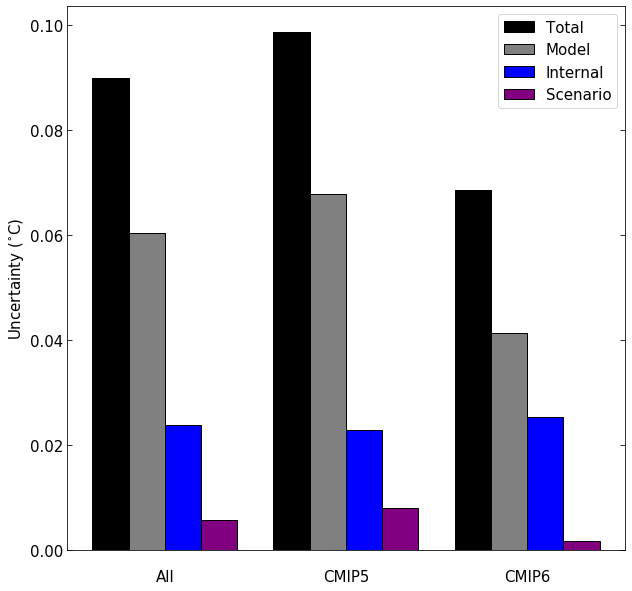

In [17]:
f,ax = plt.subplots(1,1,figsize=[10,10])
ftz=15



ax.bar(0,T[-1],color='black',width=0.5,edgecolor='black',label='Total')
ax.bar(0.5,M[-1],color='grey',width=0.5,edgecolor='black',label='Model')
ax.bar(1,I[-1],color='blue',width=0.5,edgecolor='black',label='Internal')
ax.bar(1.5,S[-1],color='purple',width=0.5,edgecolor='black',label='Scenario')


ax.bar(2.5,T_cmip5[-1],color='black',width=0.5,edgecolor='black')
ax.bar(3,M_cmip5[-1],color='grey',width=0.5,edgecolor='black')
ax.bar(3.5,I_cmip5[-1],color='blue',width=0.5,edgecolor='black')
ax.bar(4,S_cmip5[-1],color='purple',width=0.5,edgecolor='black')



ax.bar(5,T_cmip6[-1],color='black',width=0.5,edgecolor='black')
ax.bar(5.5,M_cmip6[-1],color='grey',width=0.5,edgecolor='black')
ax.bar(6,I_cmip6[-1],color='blue',width=0.5,edgecolor='black')
ax.bar(6.5,S_cmip6[-1],color='purple',width=0.5,edgecolor='black')



#ax.bar(7.5,T_low,color='black',width=0.5,edgecolor='black')
#ax.bar(8,uncertainties_low.M_low[-1],color='grey',width=0.5,edgecolor='black')
#ax.bar(8.5,uncertainties_low.I_low[-1],color='blue',width=0.5,edgecolor='black')
#ax.bar(9,uncertainties_low.S_low[-1],color='purple',width=0.5,edgecolor='black')
#
#
#
#ax.bar(10,T_med,color='black',width=0.5,edgecolor='black')
#ax.bar(10.5,uncertainties_med.M_med[-1],color='grey',width=0.5,edgecolor='black')
#ax.bar(11,uncertainties_med.I_med[-1],color='blue',width=0.5,edgecolor='black')
#ax.bar(11.5,uncertainties_med.S_med[-1],color='purple',width=0.5,edgecolor='black')
#
#
#ax.bar(12.5,T_top,color='black',width=0.5,edgecolor='black')
#ax.bar(13,uncertainties_top.M_top[-1],color='grey',width=0.5,edgecolor='black')
#ax.bar(13.5,uncertainties_top.I_top[-1],color='blue',width=0.5,edgecolor='black')
#ax.bar(14,uncertainties_top.S_top[-1],color='purple',width=0.5,edgecolor='black')


ax.legend(fontsize=ftz)


ax.set_ylabel('Uncertainty ($^{\circ}$C)',fontsize=ftz)
ax.tick_params(labelsize=ftz)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                     bottom=False, top=False, left=True, right=True,length=5,direction='in')

ax.text(0.75,-0.005,'All',fontsize=ftz,ha='center',va='center')
ax.text(3.25,-0.005,'CMIP5',fontsize=ftz,ha='center',va='center')
ax.text(5.75,-0.005,'CMIP6',fontsize=ftz,ha='center',va='center')

#ax.text(8.25,-0.005,'low',fontsize=ftz,ha='center',va='center')
#ax.text(10.75,-0.005,'moderate',fontsize=ftz,ha='center',va='center')
#ax.text(13.25,-0.005,'top',fontsize=ftz,ha='center',va='center')



plt.savefig(path_fig + 'figure_03_uncertainty_ALL_CMIP5_CMIP6.png',
             dpi = 300,
            bbox_inches='tight')

In [95]:
print('Model uncertainty 2085 CMIP5:',np.round(M_cmip5[-1],3))
print('Internal uncertainty 2085 CMIP5:',np.round(I_cmip5[-1],3))
print('Scenario uncertainty 2085 CMIP5:',np.round(S_cmip5[-1],3))

print('Total uncertainty 2085 CMIP5:',np.round(M_cmip5[-1]+I_cmip5[-1]+S_cmip5[-1],3))

Model uncertainty 2085 CMIP5: 0.068
Internal uncertainty 2085 CMIP5: 0.023
Scenario uncertainty 2085 CMIP5: 0.008
Total uncertainty 2085 CMIP5: 0.099


In [96]:
print('Model uncertainty 2085 CMIP6:',np.round(M_cmip6[-1],3))
print('Internal uncertainty 2085 CMIP6:',np.round(I_cmip6[-1],3))
print('Scenario uncertainty 2085 CMIP6:',np.round(S_cmip6[-1],3))

print('Total uncertainty 2085 CMIP6:',np.round(M_cmip6[-1]+I_cmip6[-1]+S_cmip6[-1],3))

Model uncertainty 2085 CMIP6: 0.041
Internal uncertainty 2085 CMIP6: 0.025
Scenario uncertainty 2085 CMIP6: 0.002
Total uncertainty 2085 CMIP6: 0.069
